# Analysis stories from the WishDish

## 1. Introduction


### 1.1 Problem to Solve

Our objective is to organize the database of stories from the wish dish, and in particular to develop a recommendation engine for the stories.  We have two approaches:

1. A data first approach (favored by Daniel). To use Scikit-learn for computing the most important words in the stories. Then to use those words for aggregating the stories in clusters

2. A combined approach (favored by Patricio). To favor Bryan's list of words for computing the clusters of stories.  

The output of our work is the following:

1. A recommendation function which input is a story ID, and it is output are m stories which are considered closer to the data. The m is a parameter selected by the user. 

2. The clusters of stories.

3. A visualization of these clusters.

In [1]:
from __future__ import division

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.manifold import MDS
from sklearn.cluster import KMeans

import codecs 

import numpy as np
from numpy.random import random

import pandas as pd
from pandas import Series, DataFrame

import re, pprint,csv, os, sys
from scipy.spatial import distance as dist

import seaborn as sns; 
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline

import nltk
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from nltk import word_tokenize
porter = nltk.PorterStemmer()   

In [2]:
corpusdir = 'StoriesFormatDaniel/'  

## 2. Description of the Program

Our code is separated into three sections:

1. We prepare the data. The input should be the path where the files are recorded (using Daniel's format). The output of this section is a dataframe that contains the data preprocessed.  There is not data analysis or visualization in this section

2. We define the clusters. We represent our stories in a R^n vector space. The program computes the adequate n, but the user may select a smaller one for running the program faster during testing. Then, we use a spherical version of k++. An optimal number of clusters is as well, but the user may select a different one for testing purposes.  

3. We visualize our data by projecting the data into a two-dimensional space. 

### 2.1 Preparing the data.

The output of this section is a single data frame with all the information organized. The ** index of the data frame are the stories ID**. We have three functions in this section. The function BasicData produces the final output; the other functions feed on that one.

Name: StoryCleaner  
+ Input: text
+ Output: single unicode string
+ Algorithm: replaces Upper cases characters by lower cases one and steams the words in text with the poter steamer
+ Change Previous versions: We do not need to remove omit words because Scikit-learn function Tfid that makes that role unnecessary. 


Name: FileCleaner
+ input: The filename of a story in the directory
+ output: The author name, authorid, story, storyid, date, text

Name: read_files
+ input: The path where the corpusdir is lcoated
+ output: a generator that for each file in the corpus returns FileCleaner(file).

Name: BasicData 
+ input: the corpus dir
+ output: A dataframe with the information generated by FileCleaner for all the files in the corpusdir.


In [3]:
def StoryCleaner(text):    
    story = re.sub('[^a-zA-Z]',' ', text).lower()
    story = story.split(' ')
    story = [porter.stem(word) for word in story]
    story = ' '.join(story)
    return story

def FileCleaner(filename):
    f = codecs.open(corpusdir+filename)
    text = f.read()
    f.close()
    m = re.search('(?<=Written by ).*(?=\))', text)
    if m:
        author = m.group(0)
    else:
        author = u'anonymous'
    story = StoryCleaner(text)
    temp1 = re.split('_|\.',filename)
    authorid = temp1[0]
    storyid = temp1[1]
    date = temp1[2]
    return author,  authorid, story, storyid,date, text  

In [4]:
def read_files(NameCorpusdir):
    for root, dir_names, file_names in os.walk(NameCorpusdir):
        for files in file_names:
            file_path=os.path.join(root,files)
            if files[-3:] == 'txt':
                yield FileCleaner(files)

def BasicData(NameCorpusdir):
    RawStoryFrame=pd.DataFrame(np.nan, index={}, columns=["AuthorName","Date","CleanStory","AuthorID","RawText"])
    for author, date, story, storyid, authorid, text in read_files(NameCorpusdir):
        Temp=pd.DataFrame([[author, authorid, story, date, text]], 
                          index=[storyid], columns=["AuthorName","Date","CleanStory","AuthorID","RawText"])
        RawStoryFrame=pd.concat([RawStoryFrame,Temp])
    return RawStoryFrame

Next, we illustrate the output of this section. Dropping duplicates is critical. Otherwise, we will run into errors. 

In [5]:
AllData=BasicData(corpusdir).drop_duplicates()
AllData.head()

,AuthorName,Date,CleanStory,AuthorID,RawText
2011,Morgan Ainslie,20160413,written by morgan ainsli worth it ha a l...,204,(Written by Morgan Ainslie)\n\n\n\nWorth. It h...
2007,Karlee Crowe,20150727,written by karle crow in high school i n...,205,(Written by Karlee Crowe)\n\n\n\nIn high schoo...
2009,anonymous,20160503,everyon ha a stori thi stori is a journe...,206,Everyone has a story.\n\n\n\nThis story is a ...
3202,Sarah Persinger,20150807,written by sarah persing the perfect ...,207,(Written by Sarah Persinger)\n\n\n\nThe perfec...
3189,TJ McElaney,20150913,written by tj mcelaney who am i and what ...,208,(Written by TJ McElaney)\n\n\n\nWho am I and w...


### Class Clustering

We first convert out stories to vectors in R^n. Each dimension is associated with a word in the vocabulary.  

Name: MatrixStories
+ Input: Database of stories
+ Parameters:PotentialDimAmbientSpace. I reduce it whenever I am testing result, so the notebook runs faster.
+ Output: a DataFrame which columns are the words used to span our R^n. The indexes are the stories_id. The entries of the cell (story_id, word) are just old fashion counting of words.

Name: FreqStories
+ Input: an array of the processed stories
+ Parameters:PotentialDimAmbientSpace. I reduce it whenever I am testing result, so the notebook runs faster.
+ Output: The tfidf.transform of stories

In [6]:
MinDimAmbientSpace=500
Story=list( AllData["CleanStory"]); 
DataBaseSize = AllData.shape[0]

In [7]:
def MatrixStories(DataBaseStories,PotentialDimAmbientSpace=500):
    vectorizer = CountVectorizer(ngram_range=(1, 2), analyzer = 'word', max_features=PotentialDimAmbientSpace)    
    vectorizer.fit(Story)
    DimAmbientSpace= min( len((vectorizer.vocabulary_).keys()),PotentialDimAmbientSpace )
    vectorized_Stories = vectorizer.transform(DataBaseStories)
    tfidf = TfidfTransformer(norm='l2')
    X=tfidf.fit(vectorized_Stories)
    return DataFrame(vectorized_Stories.A, index = AllData.index, 
                     columns=vectorizer.get_feature_names()) 

Next, we count the words and we illustrate the behavior of some common sets of words.

In [9]:
Y=MatrixStories(Story,MinDimAmbientSpace)
Y[["believ","athlet", "beauti", "cancer","chang","colleg","my parent","love","believ","depress","father","my mom","futur"]].head()

,believ,athlet,beauti,cancer,chang,colleg,my parent,love,believ,depress,father,my mom,futur
2011,0,0,0,0,1,6,0,4,0,0,0,0,0
2007,0,0,0,0,1,3,0,2,0,1,5,0,0
2009,0,0,0,0,1,19,10,1,0,0,0,3,2
3202,4,4,1,0,1,0,0,3,4,0,0,0,0
3189,0,0,0,0,1,0,0,3,0,0,0,0,0


In [10]:
Y.columns.values;

In [11]:
def FreqStories(DataBaseStories,PotentialDimAmbientSpace=10000):
    vectorizer = CountVectorizer(ngram_range=(1, 2), analyzer = 'word', max_features=PotentialDimAmbientSpace)
    vectorizer.fit(Story)
    DimAmbientSpace= min( len((vectorizer.vocabulary_).keys()),PotentialDimAmbientSpace )
    vectorized_Stories = vectorizer.transform(DataBaseStories)
    tfidf = TfidfTransformer(norm='l2')
    tfidf.fit(vectorized_Stories)
    return tfidf.transform(vectorized_Stories)
X =FreqStories(Story,MinDimAmbientSpace);    

In [12]:
def FreqVocStories(DataBaseStories):
    DataIDs=DataBaseStories.index 
    Words= Y.columns
    df=DataFrame(np.nan, index=DataIDs, columns=Words)    
    for i in enumerate(df.index):
        for j in enumerate(df.columns):
            df[j[1]][i[1]] = X[i[0],j[0]]
    return df

In [13]:
Old_vectorizer_vocabulary={}
for i in enumerate(Y.columns):
    Old_vectorizer_vocabulary[i[1]]=i[0]
newdict=Old_vectorizer_vocabulary
num_features= len(Old_vectorizer_vocabulary)

### Selecting the best number of clusters

In [14]:
def SquaredNorm(x):
    
    '''This function takes as input a numpy ROW array x and returns its norm squared
    as a floating point number'''
    
    norm = np.dot(x,np.transpose(x))
    
    return float(norm[0])

def Distortion(X,C,L):
    
    '''This function determines the distortion of a given clustering. X is a matrix with
    the vectors that we are clustering as rows. C is a matrix with the cluster centres as rows.
    L is a list with the cluster numbers as entries'''
    
    n = len(L)
    numclusters = C.shape[0]
    dist = 0
    for k in range(n):
        Newdist = SquaredNorm(X[k,:] - C[L[k],:])
        dist+=Newdist
    return dist


F = np.zeros([1,20])
S = np.zeros([1,20])
F[0,0] = 1
Nd = num_features
alpha = np.zeros([1,20])
for k in range(1,min(21,DataBaseSize)):
    km = KMeans(init='k-means++', max_iter=100000, n_init=1, n_clusters = k)
    km.fit(X)
    labels = km.labels_
    S[0,k-1] = Distortion(X, km.cluster_centers_, labels)
    if k==1:
        F[0,k-1] = 1
    elif k == 2:
        alpha[0,k-1] = 1 - 3/(4*Nd)
        F[0,k-1] = S[0,k-1]/(alpha[0,k-1]*S[0,k-2])
    else:
        alpha[0,k-1] = alpha[0,k-2] - (1-alpha[0,k-2])/6
        F[0,k-1] = S[0,k-1]/(alpha[0,k-1]*S[0,k-2])

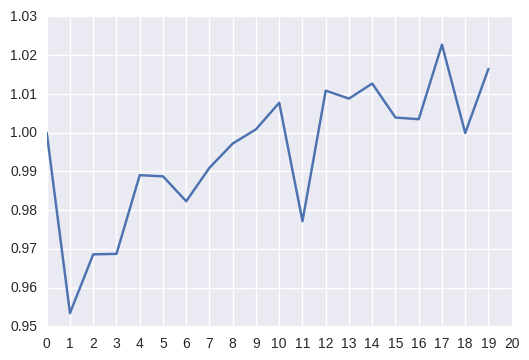

In [15]:
plt.plot(F[0,0:21])
plt.xticks(range(21))
plt.show()

The possible number of clusters are {6,11}. I select m=6. 

In [16]:
NClusters=6
km = KMeans(init='k-means++', max_iter= 100000, n_init=1, n_clusters = NClusters)
km.fit(X)
ClusterCentres = km.cluster_centers_ 
StoryClusters=DataFrame(km.labels_ , index=AllData.index, columns=["cluster"])
StoryClusters.groupby(["cluster"]).size()

cluster
0     47
1     94
2     30
3    146
4     64
5    116
dtype: int64

We want to calculate and save the distance among stories

In [17]:
def DistanceStories(DataBaseStories):
    DataIDs=AllData.index
    df=DataFrame(np.nan,index=DataIDs,columns=DataIDs)    
    for i in enumerate(df.index):
        for j in enumerate(df.index):
            df[i[1]][j[1]] = dist.euclidean(X[j[0]].toarray(), X[i[0]].toarray())
    return df

In [18]:
DS=DistanceStories(Story)

** Matrix with distance among stories **

In [19]:
DS.head()

,2011,2007,2009,3202,3189,5025,9214,2016,2049,4484,...,6342,6456,6578,737,7382,8725,8787,9184,9346,619
2011,0.000000,0.753773,0.753234,0.713778,0.852364,1.049943,1.096093,0.853821,0.860595,0.818732,...,0.949498,0.682253,0.764821,0.938580,0.866420,0.878862,1.167858,0.838425,1.113816,0.798795
2007,0.753773,0.000000,0.688132,0.672789,0.858785,1.037073,1.034635,0.852807,0.885574,0.788242,...,0.945226,0.721942,0.804691,0.875648,0.926499,0.830397,1.191038,0.758024,1.066951,0.840069
2009,0.753234,0.688132,0.000000,0.630407,0.846253,0.996645,1.019874,0.829150,0.817517,0.724750,...,0.865278,0.621252,0.710915,0.869853,0.864547,0.752323,1.161525,0.790125,1.077645,0.772262
3202,0.713778,0.672789,0.630407,0.000000,0.737420,0.965105,0.979097,0.713247,0.709299,0.589566,...,0.863993,0.617602,0.688142,0.791189,0.715604,0.837837,1.113641,0.725582,1.042282,0.725366
3189,0.852364,0.858785,0.846253,0.737420,0.000000,0.930845,0.992026,0.869997,0.855133,0.814417,...,0.953678,0.828639,0.902457,0.815209,0.827882,1.011573,1.126736,0.827456,1.134890,0.879982


Next, we implement our recomendation function. By returning the m stories that are closes to the given one. 

In [20]:
def Recomendations(StoryID,m):
    return (DS[StoryID].sort_values()).index[1:m+1]

In [21]:
Recomendations("31",3)

Index([u'8887', u'378', u'9086'], dtype='object')

## Visualization by projecting to a two-dimensional plane.

We add the centroids to the points, and then we use MDS to project the points to a two-dimensional plane. Notice that the projection preserves the order of the points.

In [22]:
mds = MDS(metric=True, n_components=2, max_iter=300, eps=1e-6)
XE=np.concatenate((X.toarray(), ClusterCentres ), axis=0)
pos = mds.fit(XE).embedding_

Now, I agrupate the projected points by their clusters

In [24]:
Clouds2D=[]
for k in range(0,NClusters):
    Clouds2D.append([list(pos[i]) for i in range(0,DataBaseSize) if StoryClusters["cluster"][i]==k])
Centroids=[]
for k in range(DataBaseSize,pos.shape[0]):
    Centroids.append(list(pos[k]))

In [27]:
colors=["b","g","r","c","m","y","black"]
CentroidsColors=["b","g","r","c","m","y","black"]

In [28]:
def Ploting(Output_of_FreqStories): 
    XF=Output_of_FreqStories
    
    mds = MDS(metric=True, n_components=2, max_iter=300, eps=1e-6)
    XE=np.concatenate((XF.toarray(), ClusterCentres ), axis=0)
    pos = mds.fit(XE).embedding_
    
    Clouds2D=[]
    for k in range(0,NClusters):
        Clouds2D.append([list(pos[i]) for i in range(0,DataBaseSize) if StoryClusters["cluster"][i]==k])
    
    Centroids=[]
    for k in range(DataBaseSize,pos.shape[0]):
        Centroids.append(list(pos[k]))
    
    colors=["b","g","r","c","m","y","black"]
    CentroidsColors=["b","g","r","c","m","y","black"]    

    Variables=[["x{0}".format(i),"y{0}".format(i)] for i in range(NClusters)]   
    VarCen=[["c{0}".format(i),"d{0}".format(i)] for i in range(NClusters)]
    
    for i in enumerate(Variables[0:NClusters]):
        i[1][0], i[1][1]= np.array(Clouds2D[i[0]])[:,0],np.array(Clouds2D[i[0]])[:,1]

    for k in enumerate(VarCen[0:NClusters]):
        k[1][0], k[1][1]=np.array(Centroids)[k[0],0],np.array(Centroids)[k[0],1]

    plt.figure(figsize=(12,12))
    plt.figure(1)
    plt.subplot(211)

    for i,j in zip(Variables[0:NClusters],colors[0:NClusters]):
        plt.scatter(i[0],i[1], color=j,  s=20)

    for i,j in zip(VarCen[0:NClusters],colors[0:NClusters]):    
        plt.scatter(i[0],i[1], color=j,  s=100, alpha=1, marker="s",edgecolors="k")


    plt.xlabel('y')
    plt.ylabel('x')
    plt.title("Projections of all the Stories into a plane ")    

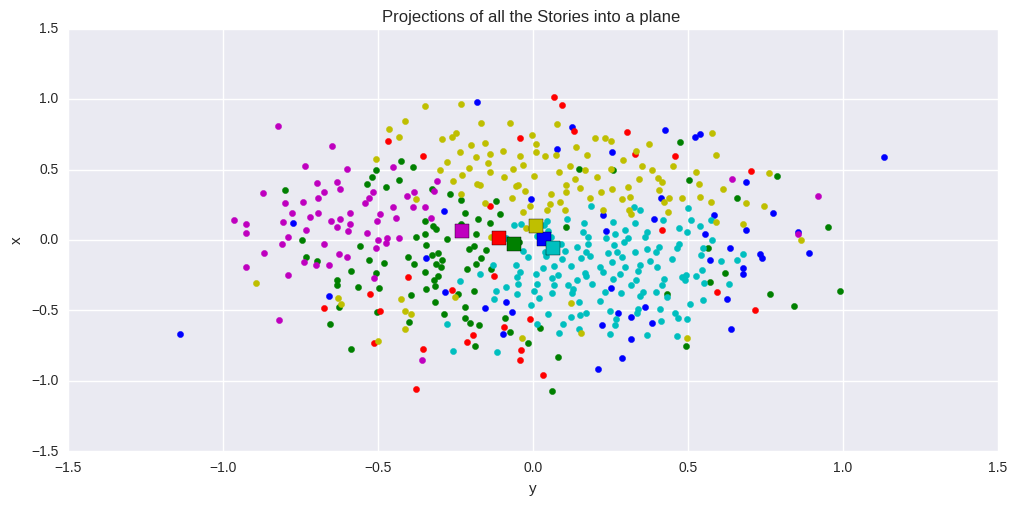

In [29]:
Ploting(X)

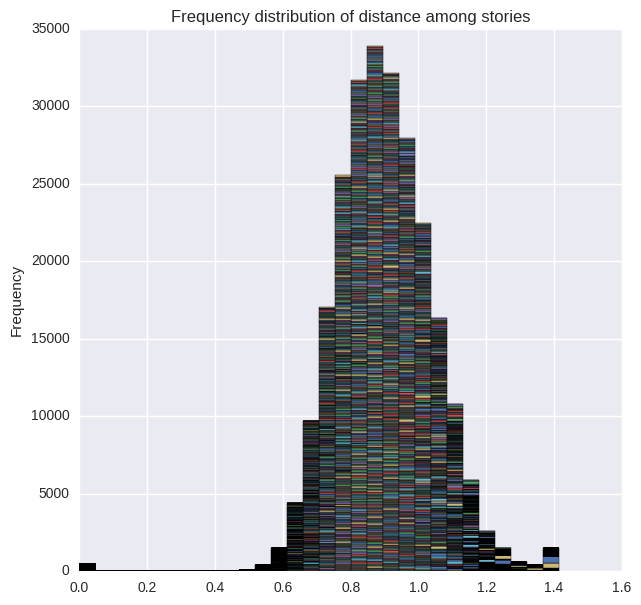

In [31]:
DS.plot.hist(bins=30,stacked=True,label=None ,figsize=(7,7),legend=False)
plt.title("Frequency distribution of distances among stories") 
plt.show()

### Bibliography

The structue of the report is taken from  http://www.d.umn.edu/~rmaclin/cs1621/lab-report.html)

The code of the function readFiles() is based on the blog post 
http://zacstewart.com/2015/04/28/document-classification-with-scikit-learn.html

The function to compute 